## Assignment 1: Build a Toy Llama-2 Language Model

> CISC7021 Applied Natural Language Processing (2024/2025)

In this assignment, we will prepare a toy language model that employs the **Llama-2** architecture and evaluate the perplexity of the data set.

We will learn how to perform continual pre-training of a base language model using the PyTorch and Hugging Face libraries. Detailed instructions for building this language model can be found in the attached notebook file.

Acknowledgement: The base model checkpoint is converted from [llama2.c](https://github.com/karpathy/llama2.c) project. The data instances were sampled from [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories) dataset.

---

🚨 Please note that running this on CPU may be slow. If running on Google Colab or Kaggle, you can avoid this by going to **Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**. This should be included within the free tier of Colab.

---

We start by doing a `pip install` of all required libraries.
- 🤗 `transformers`, `datasets`, `accelerate` are Huggingface libraries.
- By default, Colab has `transformers`, `pytorch` libraries installed. If you are using a local machine, please install them via `pip` or `conda`.

In [ ]:
#!pip install torch torchvision torchaudio
#!pip install transformers

In [ ]:
!pip install datasets accelerate -q

### (Optional) Uploading the model/data to Google Colab or Kaggle.

Please upload your dataset and model to computational platforms if you are using Colab or Kaggle environments.

For Colab users, you can mount your Google Drive files by running the following code snippet:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Necessary Packages, Environment Setups

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import torch
import transformers

from typing import List, Optional, Tuple, Union
from transformers import LlamaForCausalLM, LlamaTokenizer, AutoTokenizer
from transformers import Trainer, TrainingArguments
from itertools import chain
from datasets import load_dataset

from tqdm.notebook import tqdm
from torch.nn import CrossEntropyLoss

Please set the correct file path based on your environment.

- If you are using Colab, the path may be: `/content/drive/MyDrive/xxxxxx`
- If you are using Kaggle, the path may be: `/kaggle/input/xxxxxx`

In [4]:
# Please set the correct file path based on your environment.
TRAIN_FILE = 'data/zh_train.jsonl'
VALIDATION_FILE = 'data/zh_dev.jsonl'
TEST_FILE = 'data/zh_test.jsonl'
EN_TEST_FILE = 'data/en_test.jsonl'
MODEL_FOLDER = "llama-42m"

Load the model checkpoint into either a GPU or CPU (training will be slow on CPU, but decoding will be fair).

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device type: {device}")

model_path = MODEL_FOLDER
# Load model from local files
model = LlamaForCausalLM.from_pretrained(model_path).to(device)
# Load tokenizer from local files
tokenizer = AutoTokenizer.from_pretrained(model_path, device=device)

if tokenizer.pad_token is None: # check if the tokenizer has defined pad_token (<pad>)
    tokenizer.pad_token = tokenizer.eos_token

Device type: cuda


As we can see from the statistics, this model is much smaller than Llama-2 but shares the same decoder-only architecture.


😄 **You do not need to check complex details!** We just present the architecture and number of parameters here.

In [5]:
total_para = sum(v.numel() for k, v in model.state_dict().items() if k != 'model.embed_tokens.weight') / 1e6
print(model)
print(f"#Parameters: {total_para:.2f}M")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 512)
    (layers): ModuleList(
      (0-7): 8 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=512, out_features=1376, bias=False)
          (up_proj): Linear(in_features=512, out_features=1376, bias=False)
          (down_proj): Linear(in_features=1376, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((512,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((512,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((

### Task 1: Decoding


If you are familar with the usage of `model.generate()` function in transformer library, please feel free to jump to [Task 1 Playground](#scrollTo=Task_1_Playground).


#### 💡Tutorials: model.generate() function.
---
Minimal example:

```python
prompt = "Once upon a time, " # Input, prefix of generation
```

**Step 1**: Encode raw text using tokenizer model.
```python
tokenized_input = tokenizer.encode(prompt, return_tensors='pt').to(device)
```

**Step 2**: Set decoding hyper-parameters. Get the model output.
```python
output_ids = model.generate(tokenized_input, do_sample=True, max_new_tokens=300, temperature=0.6)
```
Important parameters:
- `max_new_tokens`: The maximum numbers of tokens to generate, ignoring the number of tokens in the prompt.
- `temperature`: The value of temperature used to modulate the next token probabilities. Higher temperature -> generate more diverse text. Lower temperature -> generate more deterministic text.
- `do_sample`: `do_sample=False` is using greedy decoing strategy. To enable greedy decoding, we also need to set other sampling parameters `top_p`, `temperature` as `None`.
- [If you are interested in other decoding algorithms, please refer to this link for setting parameters.](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/text_generation#transformers.GenerationConfig)

**Step 3**: Convert model outputs into raw text.
```python
output_text = tokenizer.decode(output_ids[0])
```
or (when input instances >=1)
```python
output_text = tokenizer.batch_decode(output_ids)
```
Important parameters:
- Setting `skip_special_tokens=True` will prevent special tokens, such as `<s>`, from appearing in the results..

---


To understand the outputs of each step, let us do a simple generation task step by step! (Note: the base model is only able to produce fluent story text).

In [6]:
prompt = "Once upon a time, Stella Lou had a dream." # Feel free to use other generation prefix

In [7]:
# Step 1: Encode raw text using tokenizer model. Run tokenization and covert strings into token ids in vocabulary.
tokenized_input = tokenizer.encode(prompt, return_tensors='pt').to(device)
# See the tokenized results.
print(tokenized_input)

tensor([[    1,  9038,  2501,   263,   931, 29892,   624,  3547,  4562,   750,
           263, 12561, 29889]], device='cuda:0')


In [8]:
# Step 2: Set decoding hyperparameters.

# For greedy decoding
max_new_tokens = 300
do_sample = False  # `do_sample=False` means using greedy decoing strategy. To enable greedy decoding, we also need to set `top_p`, `temperature` as `None`.
temperature = None

# call generation function model.generate()
output_ids = model.generate(
    tokenized_input,
    max_new_tokens=max_new_tokens,
    eos_token_id=1,
    do_sample=do_sample,
    temperature=temperature,
    top_p=None,
)

# The decoded results are token ids.
print("=" * 20 + "Token IDs" + "=" * 20)
print(output_ids)

====================Token IDs====================
tensor([[    1,  9038,  2501,   263,   931, 29892,   624,  3547,  4562,   750,
           263, 12561, 29889,  2296,  5131,   304,   367,   263, 12456,   985,
         29889,  2296,  5131,   304, 19531,   263,  9560, 10714,   322,   263,
           528,  4901, 20844, 29889,  1205,  1183,   471,  2086,  2319,   322,
           278, 10714,   471,  2086,  4802, 29889,    13,  6716,  2462, 29892,
           624,  3547,  4446,   263,  4802, 29892,   528,  4901, 10714,   297,
           263,  3787, 29889,  2296,  4433,   902, 16823,   565,  1183,  1033,
           505,   372, 29889,  2439, 16823,  1497,  4874,   322, 18093,   372,
           363,   902, 29889,    13,   855,  3547,   471,   577,  9796, 29889,
          2296,  1925,   373,   278, 10714,   322,  3252,   381,   839,  2820,
         29889,  2296,  7091,   763,   263,  1855, 12456,   985, 29889,    13,
          6246,   769, 29892,  1554,  8515,  9559, 29889,   624,  3547,  4687,
  

In [9]:
# Step 3: Convert model outputs into raw text.
# decode token ids into tokens
print("=" * 20 + "Decoded Results" + "=" * 20)
# We only have one input instance. So we directly decode the first item of model output, i.e., `output_ids[0]`.
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

====================Decoded Results====================
Once upon a time, Stella Lou had a dream. She wanted to be a princess. She wanted to wear a beautiful dress and a shiny crown. But she was too small and the dress was too big.
One day, Stella saw a big, shiny dress in a store. She asked her mom if she could have it. Her mom said yes and bought it for her.
Stella was so happy. She put on the dress and twirled around. She felt like a real princess.
But then, something strange happened. Stella started to feel dizzy. She couldn't stand up straight. She felt like she was spinning around and around.
Stella's mom saw her and said, "Stella, you need to take a break. You look dizzy."
Stella took off the dress and lay down on the floor. She closed her eyes and took a deep breath. After a few minutes, she felt better.
Stella smiled and said, "Mom, I'm ready to be a princess again!"


#### Another pipeline example: Sampling decoding with temperature.

In [10]:
prompt = "Once upon a time, Stella Lou had a dream."

# Decoding hyperparameters
max_new_tokens = 300
do_sample = True
# The value of temperature used to modulate the next token probabilities.
# Higher temperature -> generate more diverse text. Lower temperature -> generate more deterministic text.
temperature = 0.3

tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
output_ids = model.generate(
    tokenized_input,
    max_new_tokens=max_new_tokens,
    eos_token_id=1,
    do_sample=do_sample,
    temperature=temperature,
)
output_text = tokenizer.decode(output_ids[0])
print(output_text)


<s> Once upon a time, Stella Lou had a dream. In her dream, she was in a big field. The field was full of flowers and trees. She was so happy!
Suddenly, Stella heard a voice. It was a little girl. She said, "Hi, I'm Mia. What's your name?"
Stella smiled and said, "My name is Stella. I'm in this field."
Mia said, "It's so nice here. I'm so happy to be here."
Stella said, "Me too. I'm so glad you're here."
Mia and Stella talked and laughed for a long time. They became good friends.
When it was time to go, Stella said goodbye to Mia. She was so happy to have a new friend. She waved goodbye and went home.
Stella's dream had come true! She was so happy.<s>


#### Task 1 Playground

---

📚 Task 1: Please generate English stories using various prompts and decoding settings. Please feel free to explore any interesting phenomena, such as the impact of different prompts and the effects of various decoding algorithms and parameters. For example, quantify the text properties using linguistic-driven metrics like story length and Type-Token Ratio (TTR). In addition to objective metrics, you are encouraged to discuss your findings based on subjective case studies.

We provide two types of skeleton code: one that takes a single prompt as input and another that can process batched inputs and decoding. Please use the version that best fits your preferences and data types.

---

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 计算余弦相似度
def cosine_similarity(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    similarity = dot_product / (norm_a * norm_b)
    # print(vec1, vec2)
    # print(similarity)
    return similarity

# 计算欧氏距离
def euclidean_distance(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    return np.linalg.norm(vec1 - vec2)

def get_sentence_vector(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    attention_mask = inputs['attention_mask']  # 获取注意力掩码
    with torch.no_grad():
        # 获取模型的中间层隐藏状态
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # 使用最后一层的隐藏状态
        
        # 将注意力掩码扩展到嵌入维度
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()

        # 对实际的 token 进行加权平均
        sentence_vector = torch.sum(hidden_states * attention_mask_expanded, dim=1) / attention_mask_expanded.sum(dim=1)
        sentence_vector = sentence_vector.cpu().numpy()

    return sentence_vector.squeeze()


In [12]:
# Skeleton Code: Single input (same as previous code blocks)

prompt = "Once upon a time, Stella Lou had a dream." # ⬅️ try to construct different prompts.

# ⬇️ Try to tune different decoding hyperparameters.
# You can also add more hyperparameters like `top_p`, `top_k`.
max_new_tokens = 300
do_sample = True
temperature = 0.9

tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
output_ids = model.generate(
    tokenized_input,
    max_new_tokens=max_new_tokens,
    eos_token_id=1,
    do_sample=do_sample,
    temperature=temperature,
)
output_text = tokenizer.decode(output_ids[0])
print(output_text)

<s> Once upon a time, there was a big, big elephant. He was so large that he could not fit in the tiny house in the jungle. One day, he met a little monkey.
"Hello, little monkey. What are you doing?" asked the elephant.
"I am looking for a place to play," said the monkey.
The elephant said, "I can help you. Follow me."
The elephant led the monkey to a field where there were lots of trees and bushes. The monkey was happy and started to play.
"Thank you, Mr. Elephant. You are my friend," said the monkey.
"You are welcome, little monkey. I am happy to help," said the elephant.
From that day on, the elephant and the monkey played together every day. The elephant would always lead the way and the monkey would follow him. They were the best of friends.<s>


  0%|          | 0/1 [00:00<?, ?it/s]

Temperature: 0.05, Mean Perplexity: 3.0
Temperature: 0.05, Generating distance matrix...


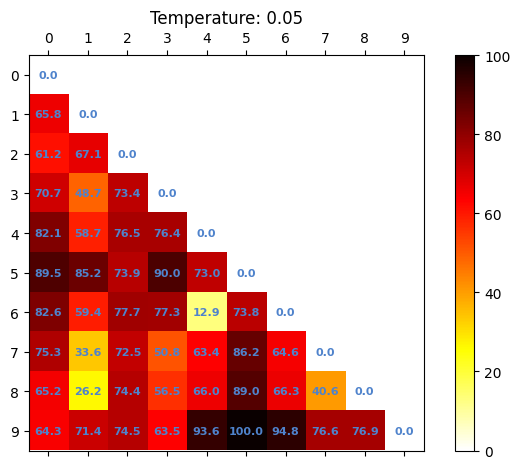

  0%|          | 0/1 [00:00<?, ?it/s]

Temperature: 0.5, Mean Perplexity: 3.2
Temperature: 0.5, Generating distance matrix...


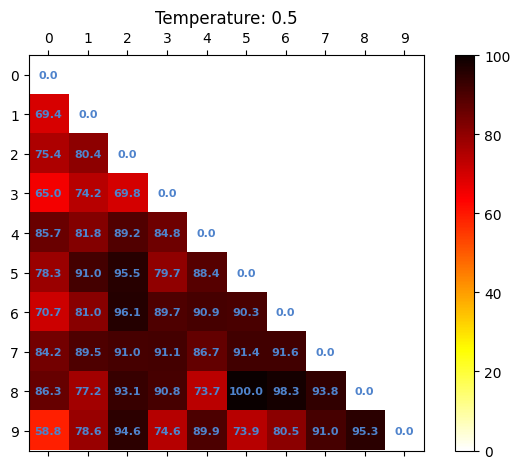

  0%|          | 0/1 [00:00<?, ?it/s]

Temperature: 1, Mean Perplexity: 4.7
Temperature: 1, Generating distance matrix...


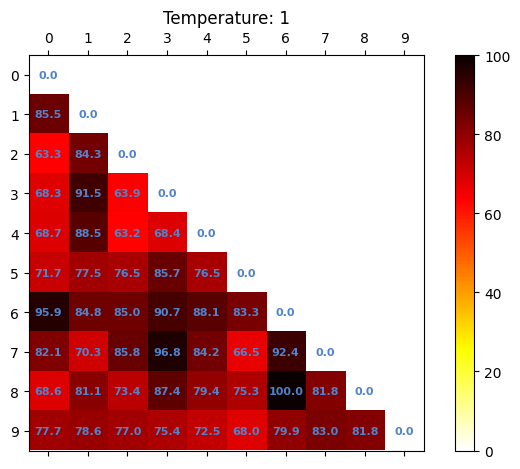

  0%|          | 0/1 [00:00<?, ?it/s]

Temperature: 1.5, Mean Perplexity: 14.0
Temperature: 1.5, Generating distance matrix...


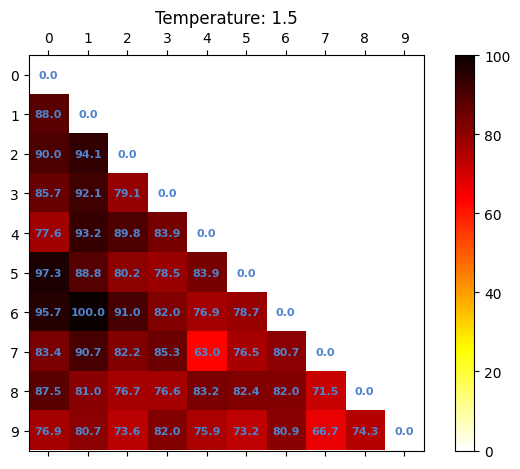

  0%|          | 0/1 [00:00<?, ?it/s]

Temperature: 1.95, Mean Perplexity: 44.0
Temperature: 1.95, Generating distance matrix...


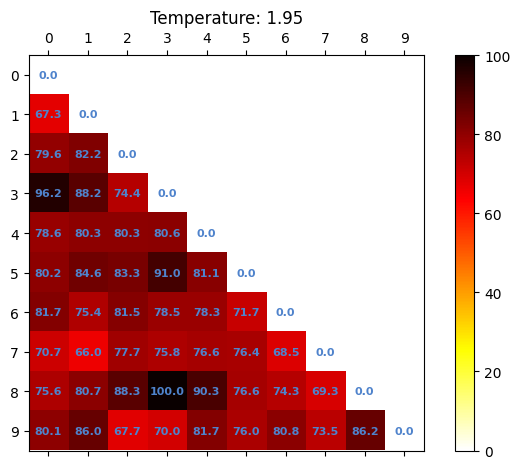

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_lower_triangle_distance_matrix(response_list, temp):
    distance_matrix = np.zeros((len(response_list), len(response_list)))
    vectors = [get_sentence_vector(response) for response in response_list]

    # 计算欧氏距离并只保留下三角矩阵
    for i in range(len(response_list)):
        for j in range(len(response_list)):
            if i >= j:  # 只保留下三角部分
                distance_matrix[i][j] = euclidean_distance(vectors[i], vectors[j])
            else:
                distance_matrix[i][j] = np.nan  # 上三角设为 NaN，不显示

    # 标准化距离矩阵，以确保不同图的颜色范围一致
    min_dist = np.nanmin(distance_matrix)
    max_dist = np.nanmax(distance_matrix)
    normed_matrix = (distance_matrix - min_dist) / (max_dist - min_dist) * 100

    # 绘制矩阵
    fig, ax = plt.subplots()
    cax = ax.matshow(normed_matrix, cmap=plt.cm.hot_r, vmin=0, vmax=100)  # 使用 hot_r 色图
    fig.colorbar(cax)

    # 设置标签
    ax.set_xticks(np.arange(len(response_list)))
    ax.set_yticks(np.arange(len(response_list)))

    # 在下三角矩阵格子中显示距离值
    for i in range(len(response_list)):
        for j in range(len(response_list)):
            if i >= j:  # 只在下三角显示值
                distance_value = f'{normed_matrix[i][j]:.1f}'
                ax.text(j, i, distance_value, ha='center', va='center', color='#4f83cc', fontsize=8, fontweight='bold')

    plt.title(f"Temperature: {temp}")
    plt.tight_layout()
    plt.savefig(f"lower_triangle_distance_matrix_temp_{temp}.png")
    plt.show()


# 显示距离矩阵和 Perplexity
def display_distance_and_perplexity(prompt: str, temperatures: List[float], num_samples: int, top_k: int, top_p: float, tokenizer, model, device):
    for temp in temperatures:
        temp_texts = []

        # 生成样本
        for _ in range(num_samples):
            tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
            output_ids = model.generate(
                tokenized_input,
                max_new_tokens=500,
                eos_token_id=1,
                do_sample=True,
                temperature=temp,
                top_k=top_k,
                top_p=top_p,
            )
            output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            temp_texts.append(output_text)

        # 计算平均 Perplexity
        ppl_result = compute_ppl(model, tokenizer, temp_texts, device)
        print(f"Temperature: {temp}, Mean Perplexity: {ppl_result['mean_perplexity']:.1f}")
        
        # 绘制下三角欧氏距离矩阵
        print(f"Temperature: {temp}, Generating distance matrix...")
        plot_lower_triangle_distance_matrix(temp_texts, temp)

# 示例调用
prompt = "这是一个测试示例"
temperatures = [0.05, 0.5, 1, 1.5, 1.95]
num_samples = 10  # 每个温度生成10个样本
top_k = 50
top_p = 0.9

display_distance_and_perplexity(prompt, temperatures, num_samples, top_k, top_p, tokenizer, model, device)



Top-k and top-p sampling

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_lower_triangle_distance_matrix(response_list, param_name, param_value):
    distance_matrix = np.zeros((len(response_list), len(response_list)))
    vectors = [get_sentence_vector(response) for response in response_list]

    # 计算欧氏距离并只保留下三角矩阵
    for i in range(len(response_list)):
        for j in range(len(response_list)):
            if i >= j:  # 只保留下三角部分
                distance_matrix[i][j] = euclidean_distance(vectors[i], vectors[j])
            else:
                distance_matrix[i][j] = np.nan  # 上三角设为 NaN，不显示

    # 标准化距离矩阵，以确保不同图的颜色范围一致
    min_dist = np.nanmin(distance_matrix)
    max_dist = np.nanmax(distance_matrix)
    normed_matrix = (distance_matrix - min_dist) / (max_dist - min_dist) * 100

    # 绘制矩阵
    fig, ax = plt.subplots()
    cax = ax.matshow(normed_matrix, cmap=plt.cm.hot_r, vmin=0, vmax=100)  # 使用 hot_r 色图
    fig.colorbar(cax)

    # 设置标签
    ax.set_xticks(np.arange(len(response_list)))
    ax.set_yticks(np.arange(len(response_list)))

    # # 在下三角矩阵格子中显示距离值
    # for i in range(len(response_list)):
    #     for j in range(len(response_list)):
    #         if i >= j:  # 只在下三角显示值
    #             distance_value = f'{normed_matrix[i][j]:.1f}'
    #             ax.text(j, i, distance_value, ha='center', va='center', color='#4f83cc', fontsize=8, fontweight='bold')

    plt.title(f"{param_name}: {param_value}")
    plt.tight_layout()
    plt.savefig(f"lower_triangle_distance_matrix_{param_name}_{param_value}.png")
    plt.show()


# 只探索不同的 top-k
def explore_top_k(prompt: str, top_k_values: List[int], num_samples: int, temperature: float, top_p: float, tokenizer, model, device):
    for top_k in top_k_values:
        texts = []

        # 生成样本
        for _ in range(num_samples):
            tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
            output_ids = model.generate(
                tokenized_input,
                max_new_tokens=500,
                eos_token_id=1,
                do_sample=True,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,  # 固定 top_p
            )
            output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            texts.append(output_text)

        # 计算平均 Perplexity
        ppl_result = compute_ppl(model, tokenizer, texts, device)
        print(f"Top-k: {top_k}, Mean Perplexity: {ppl_result['mean_perplexity']:.1f}")
        
        # 绘制下三角欧氏距离矩阵
        print(f"Top-k: {top_k}, Generating distance matrix...")
        plot_lower_triangle_distance_matrix(texts, "Top-k", top_k)


# 只探索不同的 top-p
def explore_top_p(prompt: str, top_p_values: List[float], num_samples: int, temperature: float, top_k: int, tokenizer, model, device):
    for top_p in top_p_values:
        texts = []

        # 生成样本
        for _ in range(num_samples):
            tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
            output_ids = model.generate(
                tokenized_input,
                max_new_tokens=500,
                eos_token_id=1,
                do_sample=True,
                temperature=temperature,
                top_k=top_k,  # 固定 top_k
                top_p=top_p,
            )
            output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            texts.append(output_text)

        # 计算平均 Perplexity
        ppl_result = compute_ppl(model, tokenizer, texts, device)
        print(f"Top-p: {top_p}, Mean Perplexity: {ppl_result['mean_perplexity']:.1f}")
        
        # 绘制下三角欧氏距离矩阵
        print(f"Top-p: {top_p}, Generating distance matrix...")
        plot_lower_triangle_distance_matrix(texts, "Top-p", top_p)


In [22]:
# 示例调用
prompt = "这是一个测试示例"
top_k_values = [5, 50, 100]  # 不同的 top-k 值
top_p_values = [0.8, 0.9, 1.0]  # 不同的 top-p 值
num_samples = 10  # 每次探索生成10个样本
temperature = 0.9  # 固定 temperature

  0%|          | 0/1 [00:00<?, ?it/s]

Top-k: 5, Mean Perplexity: 4.1
Top-k: 5, Generating distance matrix...


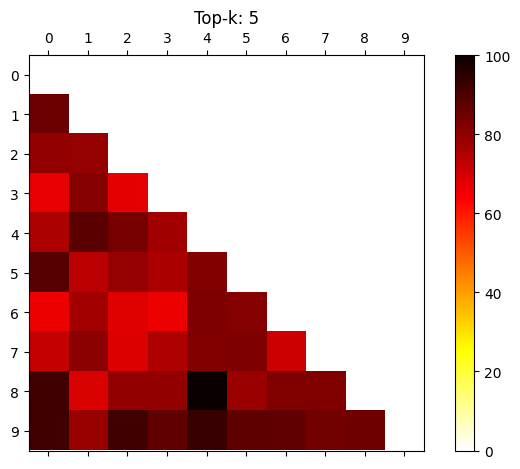

  0%|          | 0/1 [00:00<?, ?it/s]

Top-k: 50, Mean Perplexity: 4.2
Top-k: 50, Generating distance matrix...


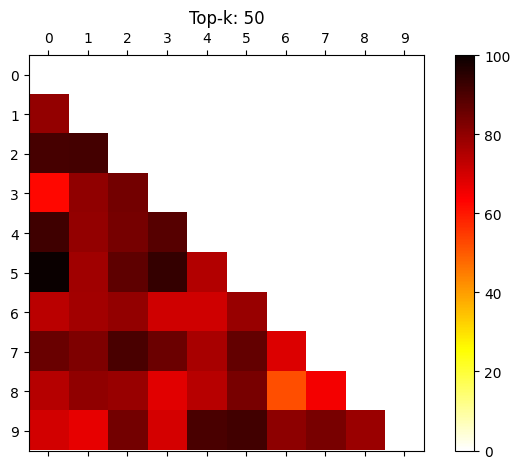

  0%|          | 0/1 [00:00<?, ?it/s]

Top-k: 100, Mean Perplexity: 4.6
Top-k: 100, Generating distance matrix...


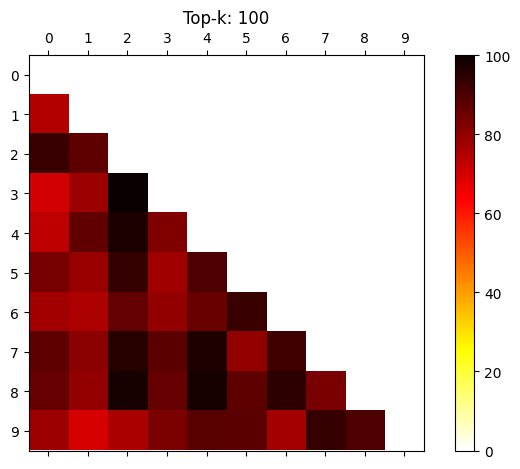

In [23]:
# 固定 top-p，探索不同的 top-k
explore_top_k(prompt, top_k_values, num_samples, temperature, top_p=0.9, tokenizer=tokenizer, model=model, device=device)


  0%|          | 0/1 [00:00<?, ?it/s]

Top-p: 0.8, Mean Perplexity: 4.7
Top-p: 0.8, Generating distance matrix...


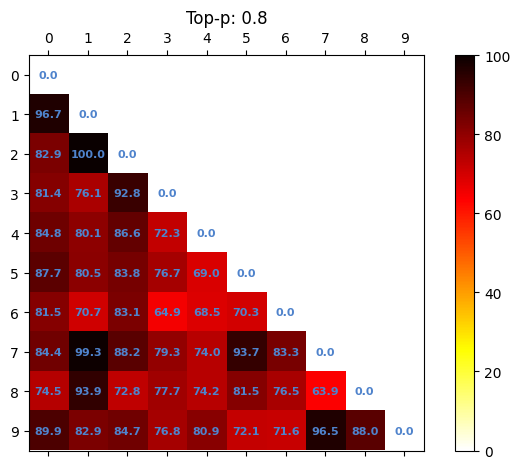

  0%|          | 0/1 [00:00<?, ?it/s]

Top-p: 0.9, Mean Perplexity: 5.1
Top-p: 0.9, Generating distance matrix...


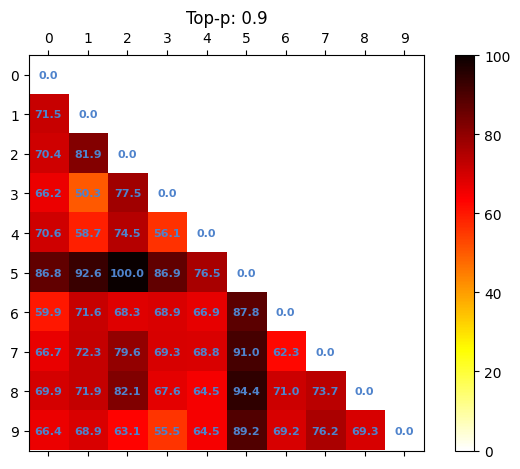

  0%|          | 0/1 [00:00<?, ?it/s]

Top-p: 1.0, Mean Perplexity: 7.4
Top-p: 1.0, Generating distance matrix...


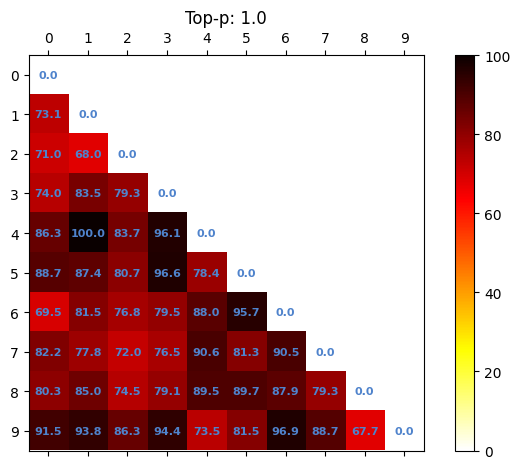

In [12]:

# 固定 top-k，探索不同的 top-p
explore_top_p(prompt, top_p_values, num_samples, temperature, top_k=50, tokenizer=tokenizer, model=model, device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Temperature: 0.2, Top-k: 10, Top-p: 0.5, Mean Perplexity: 3.1
High Certainty - Generating distance matrix...


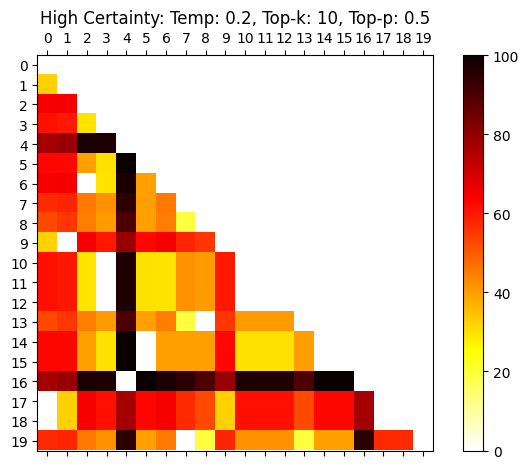

  0%|          | 0/2 [00:00<?, ?it/s]

Temperature: 1.0, Top-k: 100, Top-p: 1.0, Mean Perplexity: 7.8
Creative Generation - Generating distance matrix...


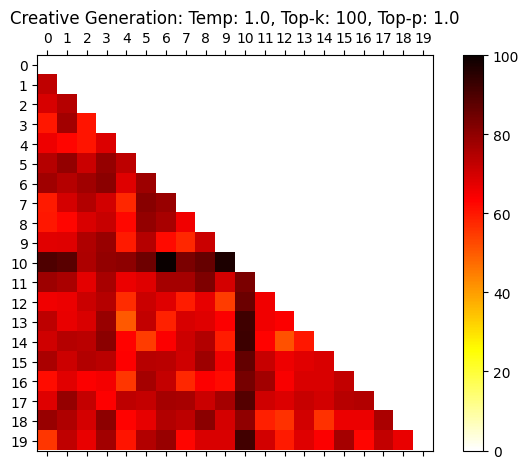

In [32]:
def explore_distinct_combinations(prompt: str, num_samples: int, tokenizer, model, device):
    # 定义特定组合
    combinations = [
        {'temperature': 0.2, 'top_k': 10, 'top_p': 0.5, 'label': 'High Certainty'},
        {'temperature': 1.0, 'top_k': 100, 'top_p': 1.0, 'label': 'Creative Generation'},
    ]
    
    for combo in combinations:
        texts = []
        temp, top_k, top_p, label = combo['temperature'], combo['top_k'], combo['top_p'], combo['label']

        # 生成样本
        for _ in range(num_samples):
            tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
            output_ids = model.generate(
                tokenized_input,
                max_new_tokens=300,
                eos_token_id=1,
                do_sample=True,
                temperature=temp,
                top_k=top_k,
                top_p=top_p,
            )
            output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            texts.append(output_text)

        # 计算平均 Perplexity
        ppl_result = compute_ppl(model, tokenizer, texts, device)
        print(f"Temperature: {temp}, Top-k: {top_k}, Top-p: {top_p}, Mean Perplexity: {ppl_result['mean_perplexity']:.1f}")
        
        # 绘制下三角欧氏距离矩阵
        print(f"{label} - Generating distance matrix...")
        plot_lower_triangle_distance_matrix(texts, label, f"Temp: {temp}, Top-k: {top_k}, Top-p: {top_p}")

# 示例调用
prompt = "这是一个测试示例"
num_samples = 20  # 每个组合生成20个样本

# 调用函数探索指定组合
explore_distinct_combinations(prompt, num_samples, tokenizer, model, device)


In [13]:
# Skeleton Code: Bacthed input-output

# prompts = ["Once upon a time,", "Tom is a cute kitty."]  # ⬅️ try to construct different prompts.
prompts = ["Once upon a time, there was a", "Jianpeng Zhao is a Ph.D student at the University of Macau.", "When I was a child,", "This story is"]

batch_size = 5 # If you have multiple data inputs, please control the batch size to prevent out-of-memory issues.

# ⬇️ Try to tune different decoding hyperparameters.
# You can also add more hyperparameters like `top_p`, `top_k`.
max_new_tokens = 300
do_sample = True
temperature = 0.6
top_p = 0.9
top_k = 5

for i in range(0, len(prompts), batch_size):
    batch_input = prompts[i:i+batch_size]
    tokenized_input = tokenizer(batch_input, return_tensors="pt", padding=True).to(device)

    # For decoder-only models, batched inputs of model.generate() should be in the format of input_ids.
    output_ids = model.generate(
        tokenized_input["input_ids"],
        max_new_tokens=max_new_tokens,
        eos_token_id=1,
        do_sample=do_sample,
        temperature=temperature,
    )
    output_text = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

    for idx, result in enumerate(output_text):
        print(f"{result}\n")

Once upon a time,y was feeling very sad. He was feeling miserable because he had no friends to play with. He was all alone in his room, but then he saw something amazing - a big box! It was filled with lots of fun toys and games. He couldn't believe his eyes! He was so excited and happy, he couldn't help but smile.
He opened the box and started playing with the toys. He was having so much fun that he didn't notice the door open. Suddenly, his mom walked in and saw the mess. She was very angry and shouted at him. She said, "What have you done! You can't just leave the room like this! You have to clean up this mess!"
But the little boy didn't want to clean up the mess. He said, "No, I don't want to! I just want to play!" His mom was very angry and she said, "If you don't clean up, I will punish you!"
The little boy didn't want to get punished, so he reluctantly started cleaning. He worked very hard and soon the mess was gone. His mom was so happy and said, "Good job! Now you can go back 

#### What about other languages?

Oops! This English language model cannot generate stories in other languages!

Why? Let us evaluate the perplexity of different languages in the next task.

In [14]:
prompt = "从前有一只小兔子乖乖"

# Decoding hyperparameters
max_new_tokens = 300
do_sample = True
temperature = 0.3

tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
output_ids = model.generate(
    tokenized_input,
    max_new_tokens=max_new_tokens,
    eos_token_id=1,
    do_sample=do_sample,
    temperature=temperature,
)
output_text = tokenizer.decode(output_ids[0])
print(output_text)


<s> 从前有一只小兔子乖乖ons were playing in the park. He was running around, laughing and having a great time. Suddenly, he saw a big, red ball. He ran over to it and started to play with it. 
"Hey!" shouted a little girl. "That's my ball!"
"No!" yelled a little girl. "That's my ball!"
The little girl started to cry. "Please give it back," she said.
The little boy didn't want to give it back. He wanted to keep playing with it. He started to cry too. 
The little girl's mom came over. She saw the little girl crying and the little boy crying. 
"What's wrong?" she asked.
The little girl said, "He took my ball and won't give it back!"
The mom smiled. "It's ok," she said. "Let's go get your ball."
The little girl smiled and they all went to get her ball. The little boy was happy to have his ball back and he was very happy to play with it again.<s>


### Task 2: Perplexity Evaluation

#### Background

---

The perplexity serves as a key metric for evaluating language models. It quantifies how well a model predicts a sample, with lower perplexity indicating better performance. For a tokenized sequence $X = (x_0, x_1, \dots, x_t)$, the perplexity is defined mathematically as:

$$\text{Perplexity}(X) = \exp \left( -\frac{1}{t} \sum_{i=1}^t \log p_\theta (x_i | x_{<i}) \right)$$

Here, $p_\theta(x_i | x_{<i})$ represents the probability of a token $ x_i $ given its preceding tokens, and the formulation incorporates the average log probability across the sequence.

---

⚠️ Please make sure to **run the following cell first** to define the evaluation function.

😄 **You do not need to check these complex details! Too hard for beginners!** However, if you are interested, you can compare the following code with the explanations above to better understand how to implement PPL evaluation using PyTorch.

In [10]:
# The following code was adapted from the `evaluate` library. Licensed under the Apache License, Version 2.0 (the "License").
# We modify them to avoid causing serious memory issues in the Colab environment.

def compute_ppl(
        model, tokenizer, inputs, device, batch_size: int = 16, add_start_token: bool = True, max_length=None
):

    if device is not None:
        assert device in ["gpu", "cpu", "cuda"], "device should be either gpu or cpu."
        if device == "gpu":
            device = "cuda"
    else:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # if batch_size > 1 (which generally leads to padding being required), and
    # if there is not an already assigned pad_token, assign an existing
    # special token to also be the padding token
    if tokenizer.pad_token is None and batch_size > 1:
        existing_special_tokens = list(tokenizer.special_tokens_map_extended.values())
        # check that the model already has at least one special token defined
        assert (
            len(existing_special_tokens) > 0
        ), "If batch_size > 1, model must have at least one special token to use for padding. Please use a different model or set batch_size=1."
        # assign one of the special tokens to also be the pad token
        tokenizer.add_special_tokens({"pad_token": existing_special_tokens[0]})

    if add_start_token and max_length:
        # leave room for <BOS> token to be added:
        assert (
            tokenizer.bos_token is not None
        ), "Input model must already have a BOS token if using add_start_token=True. Please use a different model, or set add_start_token=False"
        max_tokenized_len = max_length - 1
    else:
        max_tokenized_len = max_length

    encodings = tokenizer(
        inputs,
        add_special_tokens=False,
        padding=True,
        truncation=True if max_tokenized_len else False,
        max_length=max_tokenized_len,
        return_tensors="pt",
        return_attention_mask=True,
    )

    encoded_texts = encodings["input_ids"]
    attn_masks = encodings["attention_mask"]

    # check that each input is long enough:
    if add_start_token:
        assert torch.all(torch.ge(attn_masks.sum(1), 1)), "Each input text must be at least one token long."
    else:
        assert torch.all(
            torch.ge(attn_masks.sum(1), 2)
        ), "When add_start_token=False, each input text must be at least two tokens long. Run with add_start_token=True if inputting strings of only one token, and remove all empty input strings."

    ppls = []
    loss_fct = CrossEntropyLoss(reduction="none")

    for start_index in tqdm(range(0, len(encoded_texts), batch_size)):
        end_index = min(start_index + batch_size, len(encoded_texts))
        encoded_batch = encoded_texts[start_index:end_index].to(device)
        attn_mask = attn_masks[start_index:end_index].to(device)

        if add_start_token:
            bos_tokens_tensor = torch.tensor([[tokenizer.bos_token_id]] * encoded_batch.size(dim=0)).to(device)
            encoded_batch = torch.cat([bos_tokens_tensor, encoded_batch], dim=1)
            attn_mask = torch.cat(
                [torch.ones(bos_tokens_tensor.size(), dtype=torch.int64).to(device), attn_mask], dim=1
            )

        labels = encoded_batch

        with torch.no_grad():
            out_logits = model(encoded_batch, attention_mask=attn_mask).logits

            shift_logits = out_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            shift_attention_mask_batch = attn_mask[..., 1:].contiguous()

            perplexity_batch = torch.exp(
                (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
                / shift_attention_mask_batch.sum(1)
            )

            ppls += perplexity_batch.tolist()

    del encoded_batch, attn_mask
    if device == "cuda":
        torch.cuda.empty_cache()

    return {"perplexities": ppls, "mean_perplexity": sum(ppls)/float(len(ppls))}


#### 💡Tutorials: compute_ppl() function.

---
Minimal example:

```python
test_dataset = ["Once upon a time,"]

compute_ppl(
    model=model,
    tokenizer=tokenizer,
    device=device,
    inputs=test_dataset,
    batch_size = 16
)
```

Important parameters:
- `inputs`: list of input text, each separate text snippet is one list entry.
- `batch_size`: the batch size to run evaluations.

Returns:
- `perplexity`: `{"perplexities": [x.x, x.x, ...], "mean_perplexity": x.x}` dictionary containing the perplexity scores for the texts in the input list, as well as the mean perplexity. .


---

#### Task 2 Playground

---

📚 Task 2: Evaluate the perplexity. Ensure that you evaluate both the English and Chinese test data we provided. You are encouraged to collect more diverse text data and discuss your findings regarding the language understanding capacity of the base model.


Note: If you want to reuse the evaluation codes for JSONL data, please structure the content as follows:
```json
{"text": "one data"}
{"text": "two data."}
...
```
**You may find that the PPL value for Chinese text is significantly higher than that for English text. This is evidence that the base model cannot generate a Chinese story at the end of the last task.**

---

In [19]:
# Skeleton Code: Evaluate the perplexity (PPL) on a list of raw text.

test_dataset = ["Once upon a time,", "Tom is a cute kitty."] # ⬅️ you can use your examples / or read from raw text file

results = compute_ppl(model=model, tokenizer=tokenizer, device=device, inputs=test_dataset, batch_size = 16)
dataset_ppl = results['mean_perplexity']
print(f"Perplexity: {dataset_ppl:.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity: 10.68


In [23]:
# Skeleton Code: Evaluate the perplexity (PPL) on an external test set file (JSONL).

# English test set.
data_file = EN_TEST_FILE # ⬅️ you can change your file path
test_dataset = load_dataset('json', data_files={'test': data_file})["test"]["text"]

results = compute_ppl(model=model, tokenizer=tokenizer, device=device, inputs=test_dataset, batch_size = 16)
dataset_ppl = results['mean_perplexity']
print(f"(English Text) Test Perplexity: {dataset_ppl:.2f}")

# Chinese test set.
data_file = TEST_FILE # ⬅️ you can change your file path
test_dataset = load_dataset('json', data_files={'test': data_file})["test"]["text"]

results = compute_ppl(model=model, tokenizer=tokenizer, device=device, inputs=test_dataset, batch_size = 16)
dataset_ppl = results['mean_perplexity']
print(f"(Chinese Text) Test Perplexity: {dataset_ppl:.2f}")


# Try your own data file!

  0%|          | 0/63 [00:00<?, ?it/s]

(English Text) Test Perplexity: 4.14


  0%|          | 0/63 [00:00<?, ?it/s]

(Chinese Text) Test Perplexity: 70030.34


In [21]:
# 🚨 Release gpu cache before training the model
if device == "cuda":
    torch.cuda.empty_cache()

### Task 3: Continual Pre-training (in Chinese or in another language you are proficient in)

Currently, our base English LM is proficient in English but lacks the capability to generate or comprehend other languages (e.g., Chinese). The objective of this task is to enhance a base English LM by continually pre-training it with text in another language. This process aims to enable the model to understand and generate mini-story in another language.

We have provided 10,000 Chinese training samples. The training process for any language is the same. We have included useful resource links (in Assignment description PDF) to help you create additional data. If you encounter any issues in creating a dataset in another language, please do not hesitate to contact us.

We have implemented data preprocessing and the training pipeline, so you are not required to optimize these components. Instead, focus on tuning the training hyperparameters and observe the changes in model performance.


---

⚠️ Please **make sure to run the following cell first to pre-process data**.

😄 You do not need to check the details of whole pipeline construction! Please pay attention to the hyper-parameters of `trainer`.

#### Preprocess Data
Here, we preprocess (tokenize and group) the text for the subsequent evaluation and pre-training phases.

Load prepared Chinese dataset from Google drive (or local disk).

In [19]:
chinese_dataset = load_dataset('json', data_files={'train': TRAIN_FILE, 'validation':VALIDATION_FILE, 'test': TEST_FILE})
print(chinese_dataset)
print(chinese_dataset["test"][2]["text"])

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1000
    })
})
从前，有一个小女孩名叫莉莉。她喜欢和家人一起去度假。有一天，她的家人决定去海边旅行。莉莉非常兴奋，她跳起来又跳下去，像发了疯一样。

当他们到达海滩时，他们搭起了遮阳伞和毯子。莉莉想立刻去游泳，但她的父母告诉她要等吃完午餐再说。莉莉感到很不耐烦，她说：“我现在就想去游泳！”她妈妈回答：“莉莉，我们需要先吃东西。游泳需要能量。”

莉莉意识到妈妈说得对，于是耐心地等待午餐结束。她学会了有时候要克制自己的激动情绪，并听从父母的意见。从那天起，莉莉变得更善于倾听，也更加享受她的假期时光。


We tokenize the raw text using Llama-2's tokenizer and group the tokenized text as inputs.

In [20]:
block_size = 512

def tokenize_function(examples):
    return tokenizer(examples["text"])

def group_texts(examples):
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [21]:
tokenized_zh_datasets = chinese_dataset.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])
lm_datasets = tokenized_zh_datasets.map(
    group_texts,
    batched=True,
    batch_size=512,
    num_proc=4,
)

#### 💡Tutorials: TrainingArguments().

**Important Training Hyper-parameters**
- learning_rate: The initial learning rate for optimizer.
- num_train_epochs: Total number of training epochs to perform (if not an integer, will perform the decimal part percents of the last epoch before stopping training).
- *_strategy: The evaluation/saving strategy to adopt during training. Possible values are:
    - `"no"`: No evaluation/saving is done during training.
    - `"steps"`: Evaluation/saving is done (and logged) every `eval_steps`.
    - `"epoch"`: Evaluation/saving is done at the end of each epoch.
- per_device_train_batch_size: The batch size per GPU/XPU/TPU/MPS/NPU core/CPU for training.
- per_device_eval_batch_size: The batch size per GPU/XPU/TPU/MPS/NPU core/CPU for evaluation.
- save_total_limit: If a value is passed, will limit the total amount of checkpoints.


---

If you do not understand `AdamW` optimizer and learning scheduler, you may use default settings.

**Optimizer Hyper-parameters**
- weight_decay: The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in [`AdamW`] optimizer.
- adam_beta1: The beta1 hyperparameter for the [`AdamW`] optimizer.
- adam_beta2: The beta2 hyperparameter for the [`AdamW`] optimizer.

**Learning schedule**
- lr_scheduler: The scheduler type to use.
- warmup_ratio: Ratio of total training steps used for a linear warmup from 0 to `learning_rate`.

[Explore more parameters here](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/trainer#transformers.TrainingArguments)

#### Task 3 Playground

---

📚 Please just run the following code to do continual pre-training. Please try your best to tune the hyperparameters or collect more data to improve model performance.

---

In [22]:
# =========Pre-training hyperparameters, please feel free to tune them~=========
# =Important=
lr = 1e-4
epochs = 8
save_steps=200
strategy="steps"
train_bsz = 32 # reduce batch size if you encountered out-of-memory errors.
eval_bsz = 16

# If you do not understand AdamW optimizer and learning scheduler, you may use default settings.
# =Optimizer=
optimizer = "adamw_torch"
weight_decay = 0.01
adam_beta1 = 0.9
adam_beta2 = 0.98
# =Learning scheduler=
lr_scheduler = "linear"
warmup_ratio = 0.01
# =========End of pre-training hyperparameters=========


training_args = TrainingArguments(
    "llama-42m-zh-fairytales",
    evaluation_strategy = strategy,
    eval_steps=save_steps,
    save_strategy = strategy,
    save_steps=save_steps,
    logging_strategy="steps",
    logging_steps = 10,
    learning_rate=lr,
    weight_decay=weight_decay,
    seed=42,
    per_device_train_batch_size=train_bsz,
    per_device_eval_batch_size=eval_bsz,
    save_total_limit=1,
    optim = optimizer,
    lr_scheduler_type = lr_scheduler,
    adam_beta1 = adam_beta1,
    adam_beta2 = adam_beta2,
    warmup_ratio = warmup_ratio,
    num_train_epochs = epochs,
    report_to=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

/home/jpzhao/miniconda3/envs/CISC7021/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()

Step,Training Loss,Validation Loss
200,3.321500,3.274351
400,1.897700,1.890903
600,1.542000,1.566165
800,1.376700,1.435025
1000,1.307900,1.370766
1200,1.246400,1.322082
1400,1.173700,1.296775
1600,1.123300,1.278089
1800,1.081700,1.270050
2000,1.097800,1.264119


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


TrainOutput(global_step=2000, training_loss=1.7560472617149352, metrics={'train_runtime': 798.1341, 'train_samples_per_second': 79.876, 'train_steps_per_second': 2.506, 'total_flos': 4956004181606400.0, 'train_loss': 1.7560472617149352, 'epoch': 8.0})

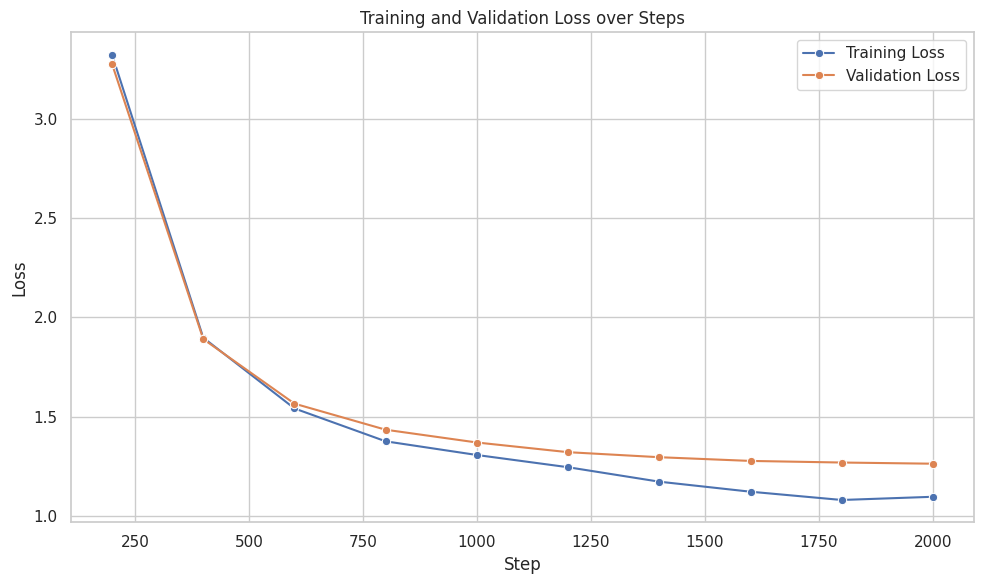

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create the dataset
data = {
    'Step': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'Training Loss': [3.321500, 1.897700, 1.542000, 1.376700, 1.307900, 1.246400, 1.173700, 1.123300, 1.081700, 1.097800],
    'Validation Loss': [3.274351, 1.890903, 1.566165, 1.435025, 1.370766, 1.322082, 1.296775, 1.278089, 1.270050, 1.264119]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set the plot style
sns.set(style="whitegrid")

# Plot both Training Loss and Validation Loss
plt.figure(figsize=(10, 6))
sns.lineplot(x='Step', y='Training Loss', data=df, label='Training Loss', marker='o')
sns.lineplot(x='Step', y='Validation Loss', data=df, label='Validation Loss', marker='o')

# Customize the plot
plt.title('Training and Validation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_validation_loss.png')
# Show the plot
plt.show()


Load pre-trained model and try to generate mini-story in another language.

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device type: {device}")

new_model_path = "llama-42m-zh-fairytales/checkpoint-2000" # saved checkpoint path
model = LlamaForCausalLM.from_pretrained(new_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path, device=device)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Device type: cuda


Evaluate the PPL on Chinese text (or another language) again.

You will notice that we actually achieve a much lower PPL after continual pre-training.

In [24]:
data_file = TEST_FILE
test_dataset = load_dataset('json', data_files={'test': data_file})["test"]["text"]

results = compute_ppl(model=model, tokenizer=tokenizer, device=device, inputs=test_dataset, batch_size = 16)
dataset_ppl = results['mean_perplexity']
print(f"Test Perplexity: {dataset_ppl:.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

Test Perplexity: 3.46


---

The original English base model was pre-trained on 2 million data samples. Considering we are using only 10,000 training samples (0.5% of the original pre-training data), the model can generate a few fluent sentences but may still struggle with long-text generation or common sense of other languages. You can try using more data or training steps depending on your computational resources.

---

In [25]:
prompt = "从前，有一只叫做汤姆的猫。汤姆和他的朋友们一起玩。"

# Decoding hyperparameters
max_new_tokens = 300
do_sample = True
temperature = 0.3

tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
output_ids = model.generate(
    tokenized_input,
    max_new_tokens=max_new_tokens,
    eos_token_id=1,
    do_sample=do_sample,
    temperature=temperature,
)
output_text = tokenizer.decode(output_ids[0])
print(output_text)

<s> 从前，有一只叫做汤姆的猫。汤姆和他的朋友们一起玩。他们喜欢在外面玩耍和奔跑。

有一天，汤姆和他的朋友们在玩球时，发现了一个大箱子。他们想知道里面有什么。他们想要一个办法让他们感到快乐。

汤姆和他的朋友们决定玩一个游戏。他们把球扔得高高的，然后扔进了箱子里。他们把球扔得高高的，然后把它们扔进了箱子里。汤姆和他的朋友们很高兴，他们整天都在玩球。<s>


In [8]:
import ollama

desiredModel = 'llama3.1:8b'
questionToAsk = 'Once upon a time, Tom is a cute kitty. Please continue generating the story (300 words).'

response = ollama.chat(model=desiredModel, messages=[
    {
        'role': 'user',
        'content': questionToAsk,
    },
])

OllamaResponse = response['message']['content']

print(OllamaResponse)

Tom was a ball of fluffy grey fur with bright green eyes that sparkled like emeralds in the sunlight. He loved to spend his days lounging in the warm sunbeams that streamed through the windows of his cozy home, chasing the occasional fly, and purring contentedly as his owner, a little girl named Lily, petted him.

Lily was Tom's best friend and companion, and she loved nothing more than to play with him whenever she had a spare moment. She'd tease him with a ball of yarn, watching as he pounced on it with glee, his tail twitching back and forth like a metronome. And when he finally caught the yarn in mid-air, Lily would squeal with delight and shower Tom with treats and praise.

But despite all the fun they had together, Tom was also a bit of a solitary creature. He loved to curl up in his favorite spot on the soft cushion, where he could watch the world go by through the window without being disturbed. And when he felt particularly sleepy, he'd stretch out across Lily's lap, purring l

In [9]:
import ollama

desiredModel = 'llama3.1:70b'
questionToAsk = 'Once upon a time, Tom is a cute kitty. Please continue generating the story (300 words).'

response = ollama.chat(model=desiredModel, messages=[
    {
        'role': 'user',
        'content': questionToAsk,
    },
])

OllamaResponse = response['message']['content']

print(OllamaResponse)

Once upon a time, Tom was indeed a cute kitty. He had soft, fluffy fur that was a beautiful shade of grey with white paws and a little pink nose. His bright green eyes sparkled with mischief, always hinting at some sort of adventure brewing in his tiny feline mind.

Tom lived with his best friend, a kind-hearted girl named Lily, in a cozy little house by the river. The sun-drenched windowsills were Tom's favorite spot to lounge around, chasing the warm rays that streamed through and watching the birds flit about outside.

One day, while Lily was busy reading a book, Tom decided it was time for an adventure. He snuck out of the open window and found himself in the lush green garden, surrounded by tall trees and buzzing bees. The scent of blooming flowers filled his nostrils, and he couldn't resist exploring every nook and cranny.

As he wandered deeper into the garden, Tom stumbled upon a tiny rabbit named Rosie. She was shy at first, but Tom's friendly meows quickly put her at ease. To

In [10]:
import requests
import json

api_key = "emhhb2ppYW5wZW5nY3NfX2dtYWlsLmNvbTpjekhOb29OY1Vt"
url = "https://fast-api.snova.ai/v1/chat/completions"

headers = {
    "Authorization": f"Basic {api_key}",
    "Content-Type": "application/json"
}

data = {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "Once upon a time, Tom is a cute kitty. Please continue generating the story (300 words)."}
    ],
    "stop": ["<|eot_id|>"],
    "model": "Meta-Llama-3.1-405B-Instruct",
    "stream": True,
    "stream_options": {"include_usage": True}
}

response = requests.post(url, headers=headers, json=data, stream=True)

full_reply = ""

if response.status_code == 200:
    for chunk in response.iter_lines():
        if chunk:
            chunk_data = chunk.decode('utf-8').strip()
            if chunk_data == "data: [DONE]":
                continue  # 跳过 [DONE] 标记
            if chunk_data.startswith("data: "):
                chunk_json = chunk_data[len("data: "):]
                try:
                    chunk_dict = json.loads(chunk_json)
                    # 检查 choices 列表是否不为空，并且 content 存在
                    if "choices" in chunk_dict and chunk_dict["choices"]:
                        content = chunk_dict["choices"][0]["delta"].get("content", "")
                        full_reply += content
                except json.JSONDecodeError:
                    print(f"Failed to parse chunk: {chunk_json}")
    print("Complete reply:\n", full_reply)
else:
    print(f"Request failed with status code: {response.status_code}")
    print(f"Response content: {response.text}")

Complete reply:
 Once upon a time, Tom is a cute kitty. He was a ball of fluffy grey fur with bright green eyes that sparkled like emeralds in the sunlight. Tom lived in a cozy little house with his best friend, a little girl named Lily. She loved Tom with all her heart and took care of him every day.

Tom loved to spend his days lounging in the sunbeams that streamed through the windows, chasing the dust motes that danced in the air. He was a lazy kitty, but he always had a little bit of mischief in his eyes. Whenever Lily was playing with her toys, Tom would sneak up and try to bat at them, sending them rolling across the floor.

One day, while Lily was out in the garden, Tom decided to go on an adventure. He slipped out of the house and into the garden, where he spotted a butterfly fluttering around a patch of colorful flowers. Tom's ears perked up, and he crouched low to the ground, ready to pounce.

But just as he was about to spring into action, the butterfly flew away, leading T